## Домашнее задание по курсу "Математические методы визуализации данных"
### Шкунков Арсений

В качестве набора данных для тестирования алгоритма рассматривается набор MNIST.
Приведены результаты для собственной реализации, а также для имплементации t-SNE в scikit-learn для сравнения

In [25]:
import numpy as np
from sklearn import datasets
from matplotlib import pyplot as plt

### Собственная реализация t-SNE

In [30]:
class tSNE:
    def __init__(self, X, y, iterations=1000, perplexity=30.0, learning_rate=200.0):
        self.X = X
        self.y = y
        self.iterations = iterations
        self.perplexity = perplexity
        self.learning_rate = learning_rate

    def calculate_distances(self, X):
        sum_X = np.sum(np.square(X), 1)

        return -np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)

    def calculate_probability_matrix(self, distances, sigmas=None):
        if sigmas is not None:
            two_sig_sq = 2. * np.square(sigmas.reshape((-1, 1)))
            return np.exp(distances / two_sig_sq) / np.exp(distances / two_sig_sq).sum(axis=1).reshape([-1, 1])
        else:
            return np.exp(distances) / np.exp(distances).sum(axis=1).reshape([-1, 1])

    def calculate_perplexity(self, distances, sigmas):
        probability_matrix = self.calculate_probability_matrix(distances, sigmas)
        entropy = -np.sum(probability_matrix * np.log2(probability_matrix), 1)

        return 2 ** entropy

    def binary_search(self, function, tol=1e-10, iterations=10000, lower=1e-20, upper=1000.):
        for i in range(iterations):
            guess = (lower + upper) / 2.
            value = function(guess)

            if value > self.perplexity:
                upper = guess
            else:
                lower = guess

            if np.abs(value - self.perplexity) <= tol:
                break

        return guess

    def calculate_sigmas(self, distances):
        sigmas = [] 
        
        for i in range(distances.shape[0]):
            function = lambda sigma: self.calculate_perplexity(distances[i:i + 1, :], np.array(sigma))
            optimal_sigma = self.binary_search(function)
            sigmas.append(optimal_sigma)

        return np.array(sigmas)

    def calculate_p(self):
        distances = self.calculate_distances(self.X)
        sigmas = self.calculate_sigmas(distances)
        P = self.calculate_probability_matrix(distances, sigmas)

        return (P + P.T) / (2. * P.shape[0])
    
    def calculate_gradient(self, P, Q, Y, distances):
        pq = P - Q
        pq = np.expand_dims(pq, 2)
        y = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
        distances = np.expand_dims(distances, 2)
        y *= distances
        grad = 4. * (pq * y).sum(1)
        return grad
    
    def calculate_q(self, Y):
        distances = self.calculate_distances(Y)
        distances_ = np.power(1. - distances, -1)
        np.fill_diagonal(distances_, 0.)
        return distances_ / np.sum(distances_), distances_

    def fit(self, P):
        Y = np.random.normal(0., 0.0001, [self.X.shape[0], 2])

        for i in range(self.iterations):
            Q, distances = self.calculate_q(Y)
            grads = self.calculate_gradient(P, Q, Y, distances)

            Y = Y - self.learning_rate * grads

        return Y

    def fit_transform(self):
        P = self.calculate_p()
        Y = self.fit(P)

        return Y

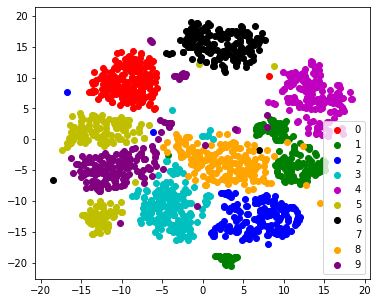

Wall time: 8min 7s


In [31]:
%%time 

digits = datasets.load_digits()
X = digits.data
y = digits.target

tsne = tSNE(X, y)

X_2d = tsne.fit_transform()

target_ids = range(len(digits.target_names))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, digits.target_names):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
plt.legend()
plt.show()

### Сравним с имплементацией в scikit-learn

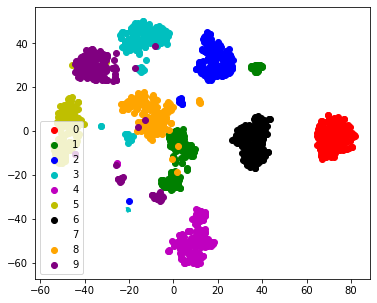

Wall time: 12.7 s


In [19]:
%%time

from sklearn.manifold import TSNE

digits = datasets.load_digits()
X = digits.data
y = digits.target

tsne = TSNE(n_components=2, random_state=0)

X_2d = tsne.fit_transform(X)

target_ids = range(len(digits.target_names))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, digits.target_names):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
plt.legend()
plt.show()